In [36]:
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller    

from statsmodels.tsa.arima.model import ARIMA         
from sklearn.metrics import mean_absolute_error   

import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

ticker = "GOOGL"
data = yf.download(ticker, period="5y", auto_adjust=True)

print(f"--- Data Types for {ticker} ---")
print(data.dtypes)

print("\n--- summary statistics ---")
print(data.describe())

print(f"\nIndex Check: Index is of type: {type(data.index)}")

[*********************100%***********************]  1 of 1 completed

--- Data Types for GOOGL ---
Price   Ticker
Close   GOOGL     float64
High    GOOGL     float64
Low     GOOGL     float64
Open    GOOGL     float64
Volume  GOOGL       int64
dtype: object

--- summary statistics ---
Price         Close         High          Low         Open        Volume
Ticker        GOOGL        GOOGL        GOOGL        GOOGL         GOOGL
count   1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03
mean     139.901046   141.426091   138.286126   139.805047  3.198236e+07
std       38.156934    38.483759    37.717878    38.112887  1.356144e+07
min       82.858521    85.927351    82.769133    84.430675  9.312000e+06
25%      112.332853   113.443564   110.896011   112.108648  2.326525e+07
50%      135.181145   136.334678   133.919337   135.128994  2.871875e+07
75%      162.970860   165.049817   161.790792   163.185963  3.638582e+07
max      291.309998   291.975006   287.320007   291.674988  1.274901e+08

Index Check: Index is of type: <class 'pandas.core.in

<Figure size 1200x600 with 0 Axes>

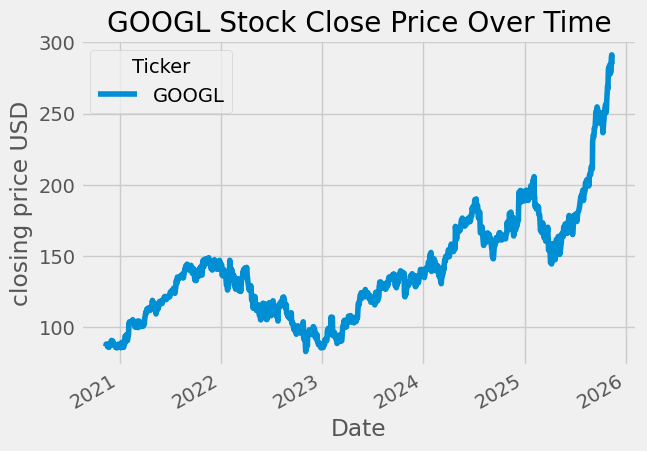

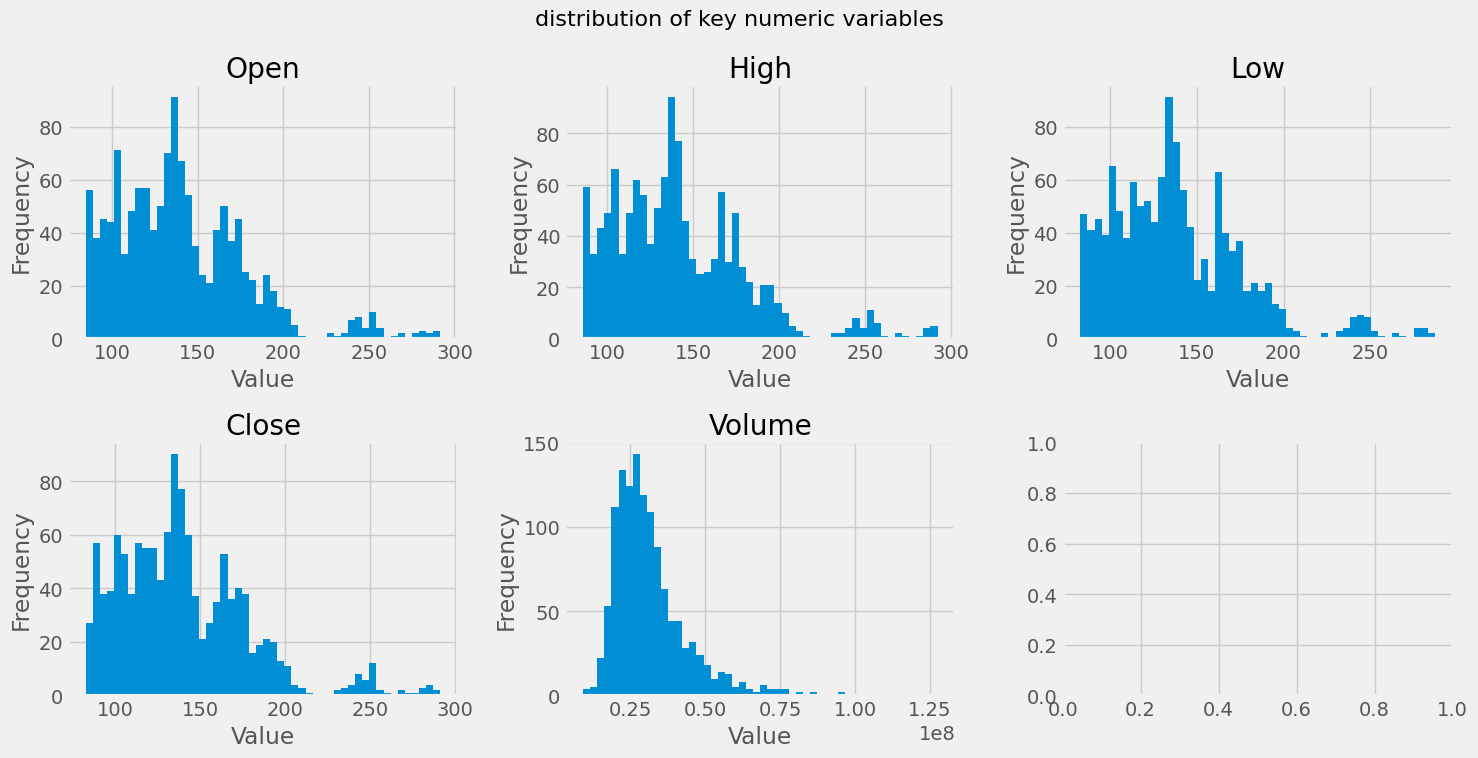

In [40]:
plt.figure(figsize=(12, 6))
data['Close'].plot(title=f'{ticker} Stock Close Price Over Time') \

plt.ylabel('closing price USD')
plt.xlabel('Date')

plt.grid(True)
plt.show()

cols = ['Open', 'High', 'Low', 'Close', 'Volume'] 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

fig.suptitle('distribution of key numeric variables', fontsize=16)

for i, col in enumerate(cols):
    row = i // 3
    col_idx = i % 3
    
    data[col].hist(bins=50, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(col)
    
    axes[row, col_idx].set_xlabel('Value')
    axes[row, col_idx].set_ylabel('Frequency')
    
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

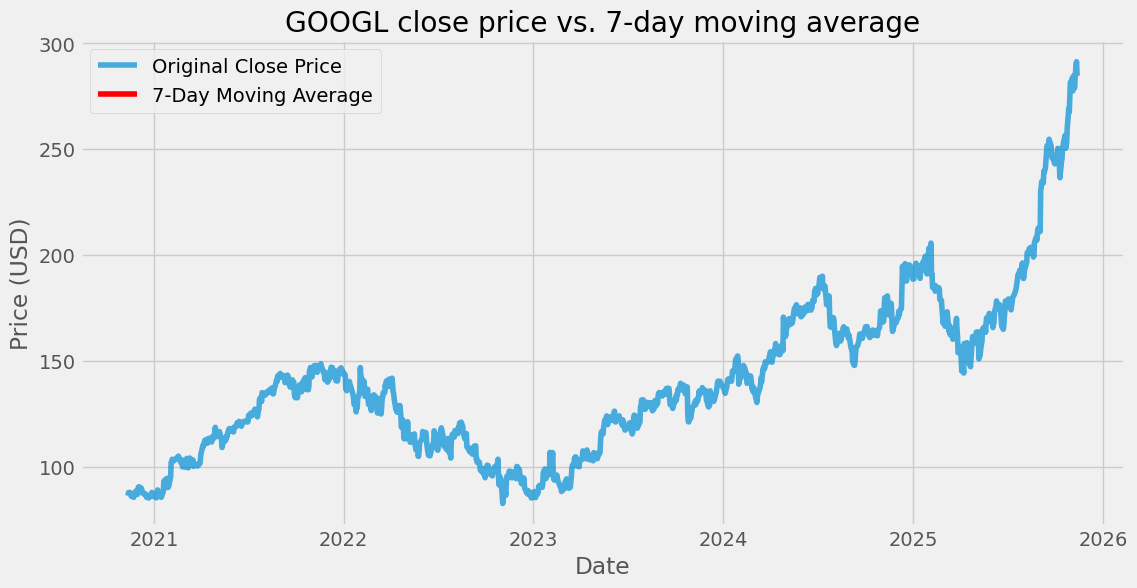

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight') 
data['MA_7_Days'] = data['Close'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Original Close Price', alpha=0.7)

plt.plot(data['MA_7_Days'], label='7-Day Moving Average', color='red') 
plt.title(f'{ticker} close price vs. 7-day moving average')

plt.xlabel('Date')
plt.ylabel('Price (USD)')

plt.legend()
plt.grid(True)

plt.show()

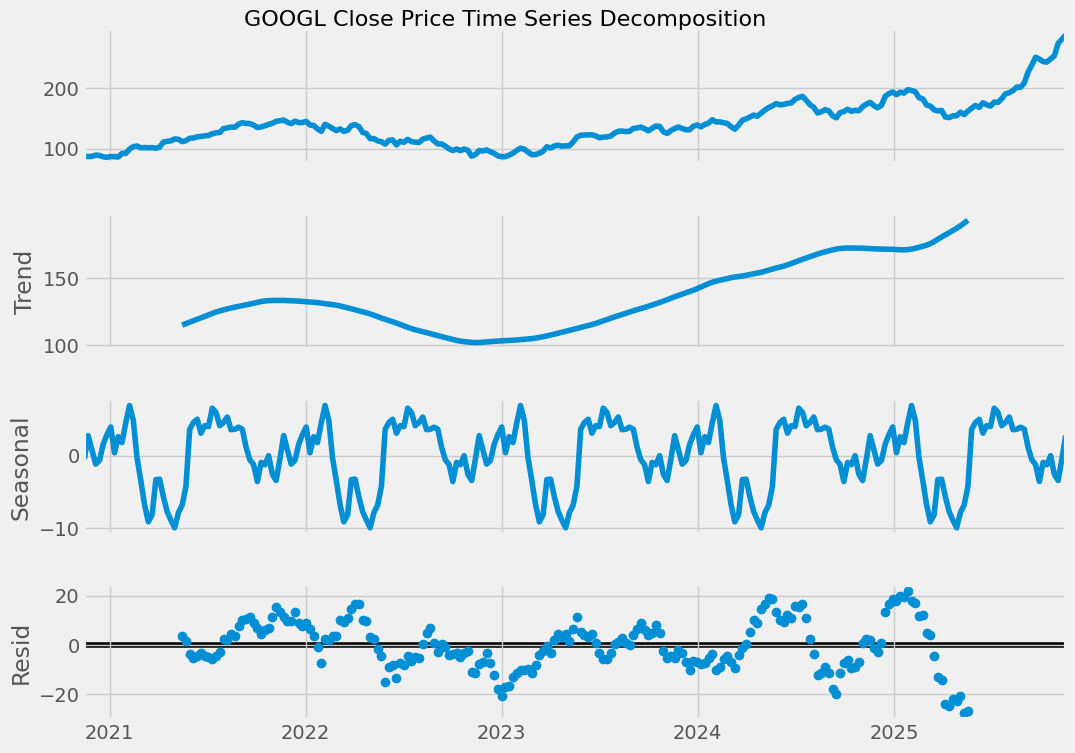

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
weekly_data = data['Close'].resample('W').mean().dropna()

decomposition = seasonal_decompose(weekly_data, model='additive', period=52) 
fig = decomposition.plot()
fig.set_size_inches(12, 8)

fig.suptitle(f'{ticker} Close price time series decomposition', fontsize=16)
plt.show()

In [68]:
from statsmodels.tsa.stattools import adfuller
volume_series = data['Volume'].dropna()

print("\n--- ADF test on volume series ---")
adf_result = adfuller(volume_series)

p_value = adf_result[1]
alpha = 0.05

print(f"ADF statistic: {adf_result[0]:.4f}")
print(f"p-value: {p_value:.4f}")
print("critical values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")
    
if p_value <= alpha:
    print("\nRESULT: p-value <= 0.05. null hypothesis rejected. series is stationary d=0.")
else:
    print("\nRESULT: p-value > 0.05. null hypothesis NOT rejected. series is non-stationary.")


--- ADF test on volume series ---
ADF statistic: -10.7546
p-value: 0.0000
critical values:
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680

RESULT: p-value <= 0.05. null hypothesis rejected. series is stationary d=0.



--- Fitting ARIMA(1, 0, 0) on volume series ---
                               SARIMAX Results                                
Dep. Variable:                  GOOGL   No. Observations:                 1226
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -21689.606
Date:                Wed, 12 Nov 2025   AIC                          43385.212
Time:                        22:36:29   BIC                          43400.547
Sample:                             0   HQIC                         43390.982
                               - 1226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.201e+07    1.5e-10   2.13e+17      0.000     3.2e+07     3.2e+07
ar.L1          0.5150      0.016     32.369      0.000       0.484       0.546
sig

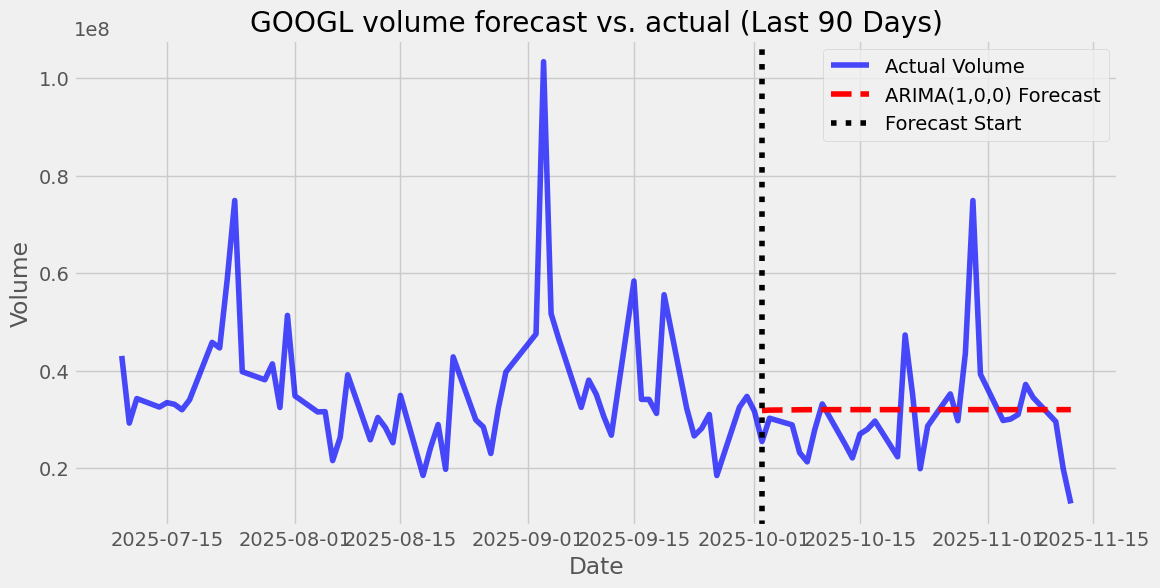


mean absolute error (MAE) for volume forecast: 7381942

--- model performance commentary hint ---
MAE: 7381942. write your conclusion about underfitting/overfitting here in your report.


In [69]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

volume_series = data['Volume'].dropna()
train_size = len(volume_series) - 30

train_data_vol = volume_series[:train_size]
test_data_vol = volume_series[train_size:]

print("\n--- Fitting ARIMA(1, 0, 0) on volume series ---")
try:
    
    model_vol = ARIMA(train_data_vol, order=(1, 0, 0)) 
    model_fit_vol = model_vol.fit()
    print(model_fit_vol.summary()) 
    
    forecast_steps = len(test_data_vol)
    forecast_object_vol = model_fit_vol.get_forecast(steps=forecast_steps)
    forecast_vol = forecast_object_vol.predicted_mean
    
    forecast_series_vol = pd.Series(forecast_vol.values, index=test_data_vol.index)
    plot_data_vol = volume_series[-90:] 
    
    plt.figure(figsize=(12, 6))
    plt.plot(plot_data_vol, label='Actual Volume', color='blue', alpha=0.7)

    plt.plot(forecast_series_vol, label='ARIMA(1,0,0) Forecast', color='red', linestyle='--')
    plt.axvline(x=test_data_vol.index[0], color='black', linestyle=':', label='Forecast Start')

    plt.title(f'{ticker} volume forecast vs. actual (Last 90 Days)')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

    mae_vol = mean_absolute_error(test_data_vol, forecast_series_vol)
    print(f"\nmean absolute error (MAE) for volume forecast: {mae_vol:.0f}")
    
    print("\n--- model performance commentary hint ---")
    print(f"MAE: {mae_vol:.0f}. write your conclusion about underfitting/overfitting here in your report.")


except Exception as e:
    print(f"an error occurred during ARIMA modeling on volume: {e}")